# Geodatenanalyse 2: Zeitreihenvorhersage und rekurrente neuronale Netze

## Zeitreihenvorhersage mit 1D-CNN

Ziel der Übung: Grundwasserstand simulieren für einen Zeitraum von 4 Jahren basierend auf meteorologischen Inputdaten (z.B. Niederschlag und Lufttemperatur). 

Mithilfe von NN können wir den Zusammenhang zwischen aufeinanderfolgenden Niederschlagsereignissen und dem vergangenen Temperaturverlauf mit dem Grundwasserstand herstellen, auch ohne die direketen Prozesse (Grundwasserneubildung, Evapotranspiration, ...) zu definieren. 



### Packages einladen und Seed setzen
Um ein reproduzierbares Ergebnis zu erhalten definieren wir zunächst die Startpunkte (seeds) der Zufallszahlengeneratoren von numpy und tensorflow:

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping

#set random seed for reproducability
from numpy.random import seed
seed(42) # this is a randomly chosen number

from tensorflow import random
random.set_seed(42) # this is also a randomly chosen number

print("seeds are set") # Outputs the text "seeds are set" to confirm that the seeds have been successfully set

2025-06-25 10:36:57.076922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 10:36:57.088016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-25 10:36:57.100468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-25 10:36:57.104178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 10:36:57.113965: I tensorflow/core/platform/cpu_feature_guar

seeds are set


### Daten einladen
Die (wöchentlich) Grundwasserdaten befinden sich in der Datei: **GW-Data.csv**  
Die (wöchentlichen) meteorologischen Inputdaten in der Datei: **Climate-Data.csv**

Wir laden die Dateien als pandas Dataframe mit einem Zeitindex (datetime) ein und führen beide Dateien zusammen. Ein weiteres Preprocessing ist in diesem Fall nicht nötig, da die Daten schon auf Datenlücken/Fehlwerte etc. untersucht und bereinigt wurden. Auch decken alle Daten den gleichen Zeitraum ab und verfügen über ein identisches Sampling Intervall (wöchentlich).

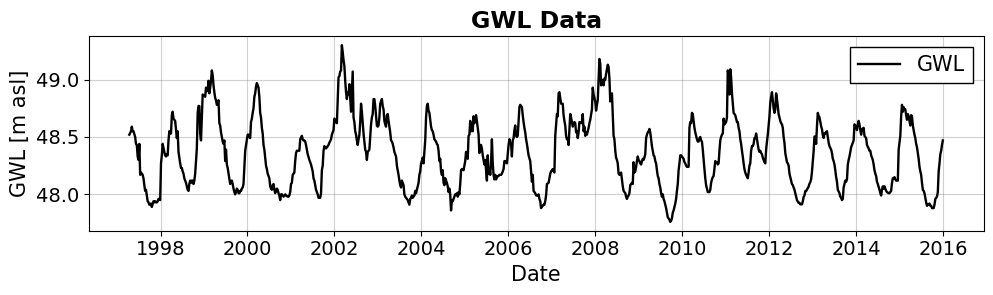

,GWL,P,rH,T,Tsin
Date,,,,,
1997-04-14,48.520,1.203046,62.731979,6.593939,-1.439494
1997-04-21,48.535,0.864522,61.926402,4.493416,-0.347873
1997-04-28,48.550,7.486455,62.071464,9.000969,0.748794
1997-05-05,48.590,30.453424,80.260318,11.661238,1.834601
1997-05-12,48.550,15.360879,71.335400,10.898702,2.893801


In [2]:
GWData = pd.read_csv('./GW-Data.csv', #reads the CSV files GW-Data.csv into Panda's DataFrame.
                     parse_dates=['Date'], #ensures that the Date column is recognised as a date and converted accordingly
                     index_col=0, #sets the first column of the CSV file as the index of the DataFrame
                     dayfirst = True, # specifies that the date format is day-month-year
                     decimal = '.', #specifies that the decimal point is used
                     sep=',') #indicates that the comma is used as the column separator

ClimateData = pd.read_csv('Climate-Data.csv', parse_dates=['Date'],index_col=0,dayfirst = True, decimal = '.', sep=',')

# Merge the Dataframes
data = pd.merge(GWData, ClimateData, how='inner', left_index = True, right_index = True) 
# merges the two DataFrames GWData and ClimateData based on their indices. how='inner' means that only the common entries of both DataFrames are included in the result



#plot GWL data
plt.figure(figsize=(10,3)) #Creates a new graphic with the specified dimensions
plt.plot(data.index, data['GWL'], 'k', label ="GWL", linewidth = 1.7) #plots the GWL data (groundwater level) against time (data.index). The colour of the line is black ('k') and the linewidth is 1.7
plt.title("GWL Data", size=17,fontweight = 'bold') #Sets the title of the plot with font size 17 and bold font
plt.ylabel('GWL [m asl]', size=15) #Labels the y-axis with GWL [m asl] and font size 15
plt.xlabel('Date',size=15)# Labels the x-axis with Date and font size 15
plt.legend(fontsize=15,loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')#adds a legend to the plot with font size 15, positioned upper right, without rounded corners (fancybox=False), an opacity of 1 and a black border (edgecolor='k')
plt.tight_layout() #djusts the layout of the graphic to avoid overlapping.
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-') #Adds a grid to the plot showing the major lines (major), with a grey colour, opacity of 0.3 and solid lines
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)#Sets the font size of the x-axis and y-axis labels to 14
plt.show() #Displays the plot

#inspect the data
data.head() 
#displays the first five lines of the DataFrame data. This is useful to get a quick overview of the data and to ensure that the data was read in and merged correctly

Der DataFrame setzt sich nun zusammen aus der Indexspalte **Date**, dem Grundwasserstand **GWL**, Niederschlag **P**, relativer Feuchte **rH**, Temperatur **T** und einem geglätteten Temperatursignal **Tsin** (Sinuskurve an T gefittet).  

Parameter **rH** und **Tsin** werden zunächst nicht benötigt (*drop*).

In [3]:
try: #Starts a try block
    data = data.drop(columns=['rH','Tsin']) #removes the columns rH and Tsin from the DataFrame
    print("dropped") #if the columns have been successfully removed, "dropped" is output
except: #If an error occurs when attempting to remove the columns (e.g. if the columns have already been removed or do not exist), the except block is executed
    print("⚠️columns already dropped") #if an error occurs, "already dropped" is output

data.head()

dropped


,GWL,P,T
Date,,,
1997-04-14,48.520,1.203046,6.593939
1997-04-21,48.535,0.864522,4.493416
1997-04-28,48.550,7.486455,9.000969
1997-05-05,48.590,30.453424,11.661238
1997-05-12,48.550,15.360879,10.898702


die *try ... except* - Syntax verhindert einen Fehler, wenn die Variablen nicht vorhanden sind oder schon entfernt wurden. In unserem Fall also z.B. wenn die Zelle im notebook bereits ausgeführt wurde.  

Wie immer führen viele Wege zum Ziel. Man könnte auch schreiben
- data.drop(columns=['rH','Tsin'], inplace = True)
- data = data.drop(['rH','Tsin'], axis = 1)
- ...

### Wir benutzen keine Einzelwerte als Inputs sondern Sequenzen!

Zunächst müssen wir also die **Input-Sequenzlänge** festlegen und die Daten so umwandeln, dass jedem GWL-Wert Sequenzen von P- und T-Werten in der entsprechenden Sequenzlänge zugeordnet sind. Wir bezeichen diesen Parameter im Folgenden als **seq_length** (*Anzahl der Input Zeitschritte*).

Hierfür definieren wir eine Funktion die genau das für uns erledigt und die wir immer wieder verwenden können: *make_sequences*    

Diese können wir nachher mit folgender Zeile aufrufen:  
*X,Y = make_sequences(data, seq_length)*


In [4]:
def make_sequences(data, seq_length): #Defines a function make_sequences that takes two arguments: data, seq_length
#     """ docstring """
#     data: numpy array with target (Y) in first column and model inputs in following columns
#     n_steps_in: number that defines the sequence length
    
#     Output:
#     X: sequenced model input data
#     Y: sequenced model target data
    
#     function modified after: machinelearningmastery.com
#     """
    
    #sequence the data
    X, Y = list(), list() #Initialises two empty lists X and Y to store the sequenced input and output data. They automatically adjust their size when elements are added. Another way to create empty lists would be X, Y = [],[]
 
    for i in range(len(data)): #Iterates through the data set, one time step at a time
        end_idx = i + seq_length #Calculates the end index of the current sequence
        if end_idx >= len(data): #Checks whether the end index goes beyond the end of the data set. If yes, the loop is cancelled
            break
        seq_x = data[i:end_idx, 1:] #Extracts the input sequence. This includes all columns except the first, from the current index i to end_idx
        seq_y = data[end_idx, 0] #Extracts the target value. This is the value in the first column at end_idx
        X.append(seq_x) #Adds the input sequence seq_x to the list X
        Y.append(seq_y) #Adds the target value seq_y to the list Y
        
    return np.array(X), np.array(Y)

### Daten splitten

Bevor wir die Daten in Sequenzen umwandeln, müssen wir aber zunächst noch den bekannten Train-Test-Split durchführen und die Daten anschließend skalieren. Wichtig, shuffling ist für Zeitreihen nicht erlaubt, wir teilen die Zeitreihe einfach in zusammenhängende Abschnitte auf. Hierfür können die bereits eingeführten Funktionen verwendet werden **ABER** besonders bei Zeitreihen bietet es sich häufig an, die Zeitpunkte an denen geteilt wird, selbst festzulegen. Es ist einfach häufig sinnvoller mit Jahren als mit prozentualen Anteilen einer Zeitreihe zu arbeiten.

Daher teilen wir nun die Zeitreihe in drei Abschnitte auf:  
**Training, Early Stopping (Validation) und Testing**  

Zum Testen sollen die Jahre 2012 bis einschließlich 2015 (also 4 Jahre) verwendet werden, für Early Stopping 2 Jahre (2010 - 2011), fürs Training die restlichen Daten davor.

Hierfür können wir den Datumsindex des Dataframe verwenden. Zunächst definieren wir uns jedoch ein Datum, zu welchem Die Daten geteilt werden sollen.

In [5]:
val_startdate = pd.to_datetime('01012010', format='%d%m%Y') # converts the character string into a timestamp object from Pandas
print("Start Stopset")
print(val_startdate)

test_startdate = pd.to_datetime('01012012', format='%d%m%Y')
print("\nStart Testset") #\n stays for new line
print(test_startdate)

TrainingData = data[(data.index < val_startdate)] #Filters the data to get all data points before val_startdate 
StopData = data[(data.index >= val_startdate) & (data.index < test_startdate)] # Filters the data to get all data points between the val_startdate (inclusive) and the test_startdate (1 January 2012, exclusive)
TestData = data[(data.index >= test_startdate)] #Filters the data to obtain all data points from the test_startdate (inclusive). This data is used for testing

Start Stopset
2010-01-01 00:00:00

Start Testset
2012-01-01 00:00:00


#### Überlappung beim Split notwendig!

Beim Teilen gilt es die eben angesprochene Sequenzlänge *seq_length* zu beachten, denn wenn die Zeitreihe zum 1.1.2012 geteilt werden sollen, so werden aus dem Jahr 2012 noch *seq_length* Zeitschritte benötigt um den ersten Wert in 2012 berechnen zu können. Die Zeiträume überlappen sich also in Bezug auf die Inputdaten *X* ( *_ext* = extended). 

Beispiel: Tagesdaten und beliebiges Modell mit *seq_length = 4*:

       28.12.2011   X        Beginn Überlapp  
       29.12.2011   X  X
       30.12.2011   X  X  X
       31.12.2011   X  X  X
       1.1.2012     Y  X  X  Beginn Testzeitraum
       2.1.2012        Y  X
       3.1.2012           Y
       [...]

Für den Trainigsdatensatz gilt entsprechend, dass der erste simulierte Wert erst nach *n_steps_in* Zeitschritten berechnet, wird. Die bis dahin ungenutzten Zielwerte werden verworfen. Bei großen Sequenzlängen kann hierdurch der Trainingszeitraum also u.U. wesentlich verkleinert werden.

In [6]:
seq_length = 30 #Defines the number of steps (time steps) that should be contained in the input sequence
                                              
StopData_ext = pd.concat([TrainingData.iloc[-seq_length:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
TestData_ext = pd.concat([StopData.iloc[-seq_length:], TestData], axis=0) #takes last steps of StopData and combines it with TestData

print(StopData_ext) #Outputs the extended validation data set (StopData_ext), which now starts n_steps_in time steps before the original val_startdate
print(TestData_ext) #Outputs the extended test data set (TestData_ext), which now starts n_steps_in time steps before the original test_startdate

              GWL          P          T
Date                                   
2009-06-08  48.16  18.420469  11.906599
2009-06-15  48.14  15.198681  13.720525
2009-06-22  48.09   4.798087  14.280552
2009-06-29  48.06  25.813226  17.236862
2009-07-06  48.01   0.303545  21.343518
...           ...        ...        ...
2011-11-28  48.27   3.403124   5.071363
2011-12-05  48.39  12.880768   4.946515
2011-12-12  48.46  29.410461   3.325727
2011-12-19  48.52  24.498789   3.517069
2011-12-26  48.60  13.230482   4.957039

[134 rows x 3 columns]
               GWL          P          T
Date                                    
2011-06-06  48.220  17.698855  18.934101
2011-06-13  48.190  18.790927  16.658239
2011-06-20  48.170  11.400212  16.487241
2011-06-27  48.155  21.831441  16.295470
2011-07-04  48.140  59.990134  16.504509
...            ...        ...        ...
2015-11-30  48.270  22.872325   3.191298
2015-12-07  48.350   3.483266   7.741861
2015-12-14  48.380  20.409523   4.794098
2015-

### Daten skalieren 
Jetzt skalieren wir die Daten auf den Wertebereich [-1,1] entsprechend des Trainingdatensatzes. Wie in der letzten Übung erstellen wir noch einen scaler der nur die Zielvariable scaled um nachher einfacher retransformieren zu können (*scaler_gwl*).

In [7]:
#fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1)) #Initialises a MinMaxScaler with a value range from -1 to 1
scaler.fit(TrainingData) #Adapts the scaler to the TrainingData, i.e. the scaler calculates the minimum and maximum values of the TrainingData in order to later transform the data into the range from -1 to 1

scaler_gwl = MinMaxScaler(feature_range=(-1, 1)) #Initialises a separate MinMaxScaler for the GWL data 
scaler_gwl.fit(pd.DataFrame(TrainingData['GWL'])) #Adapts the scaler to the GWL column of the TrainingData. Here, pd.DataFrame is used to ensure that the GWL column is in the correct format (as a DataFrame instead of a Series)

#scale data
TrainingData_n = scaler.transform(TrainingData) #Transforms the TrainingData by scaling the values in the range from -1 to 1
StopData_ext_n = scaler.transform(StopData_ext) #Transforms the extended validation data (StopData_ext)
TestData_ext_n = scaler.transform(TestData_ext) #Transforms the extended test data (TestData_ext)

Nun nutzen wir die Sequenz Funktion von oben, aus einem 2D (Länge Datensatz, Anzahl Parameter) wird damit ein 3D Datensatz mit den Dimensionen: (Länge Datensatz, seq_length (Input Sequenzlänge), Anzahl Input Parameter).
    

In [8]:
#creates sequences from the scaled training, validation and test data using the make_sequences function
X_train,Y_train = make_sequences(np.asarray(TrainingData_n), seq_length)
X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), seq_length)
X_test,Y_test = make_sequences(np.asarray(TestData_ext_n), seq_length)

print("(Länge Datensatz, Input Sequenzlänge, Anzahl Input Parameter)\n")
print("Train Input: {} \nTrain Target: {} \n".format(X_train.shape, Y_train.shape)) #dimensions of these sequences and target values to ensure that the data has been prepared correctly
print("Validation Input: {} \nValidation Target: {} \n".format(X_stop.shape, Y_stop.shape))
print("Test Input: {} \nTest Target: {} \n".format(X_test.shape, Y_test.shape))

(Länge Datensatz, Input Sequenzlänge, Anzahl Input Parameter)

Train Input: (634, 30, 2) 
Train Target: (634,) 

Validation Input: (104, 30, 2) 
Validation Target: (104,) 

Test Input: (209, 30, 2) 
Test Target: (209,) 



### Modell erstellen und kompilieren 
Diese Daten können wir nun direkt in das Modell eingeben. Dieses definieren wir im Folgenden. Wir starten mit einem **1D-CNN** und nutzen hierfür die Keras API in Tensorflow (*tensorflow.keras*):

from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM

from keras.models import Model


In [9]:
#set seed for reproducability
seed(42) 
tf.random.set_seed(42)

#Start with Input Layer (ensures that the subsequent layers receive the data in the correct form)
inp = Input(shape=(seq_length, X_train.shape[2])) #The inputs have a sequence length of seq_length and X_train.shape[2] features 

#1D Conv Layer (connect it to Input Layer (inp))
#extracts features from the input sequences. Patterns and local dependencies in the data can be recognised through convolution
cnn = Conv1D(filters=256, #define number of filters
                             kernel_size=3, #define kernel_size
                             activation='relu', #set activation to 'relu' (outputs only positive numbers) for better performance and to add non-linearity 
                             padding='same')(inp) #define same padding and connect to 'inp' Layer 

#Pooling Layer (connect it to the previous layer (conv))
cnn = MaxPooling1D(padding='same')(cnn) #Consolidates the information from the feature map by selecting the largest values in each pooling window. This reduces the dimension of the data and helps to highlight the most important features


#Flatten Layer (connect it to the previous layer (pool))
cnn = Flatten()(cnn) #converts the output of the previous layer into a flat vector.This is necessary to prepare the data for the subsequent dense layers (fully connected layers)


#add a dense layer (connect it to the previous layer (flat))
dense = Dense(30, activation='relu')(cnn) #learns more complex relationships through the non linearity of relu acitvation 


#add 1 output neuron (1 GWL Prediction) (connect it with the previous layer (dense))
output = Dense(1, activation='linear')(dense) #activation = 'linear' ensures that the output value is not restricted and can assume any real value

#Creates a model that merges the defined layers.
model = Model(inputs=inp, outputs=output)

#define optimizer
optimizer = Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
#compile the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

#print model summary to inspect the model
model.summary()

2025-06-25 10:36:58.360422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 811 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:b5:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 30, 256)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │       115,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,053 (457.24 KB)

 Trainable params: 117,053 (457.24 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ########### this part does the exact same thing as the lines above and corresponds to what you have learned last time ##########
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(n_steps_in, X_train.shape[2]))) # define the shape of the input data
# model.add(tf.keras.layers.Conv1D(filters=256,kernel_size=3,activation='relu',padding='same')) #start with a 1D-Conv Layer
# model.add(tf.keras.layers.MaxPool1D(padding='same')) #add Pooling Layer
# model.add(tf.keras.layers.Flatten())#reshape data for next layer
# model.add(tf.keras.layers.Dense(30, activation='relu')) # add a dense layer
# model.add(tf.keras.layers.Dense(1, activation='linear')) # output neuron to get meaningful output values
# ####################################################################################################################

### Modell trainieren

Epoch 1/100


I0000 00:00:1750847819.396359  693308 service.cc:146] XLA service 0x7fb754004a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750847819.396382  693308 service.cc:154]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-06-25 10:36:59.415216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-25 10:36:59.534772: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1750847820.046594  693308 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100


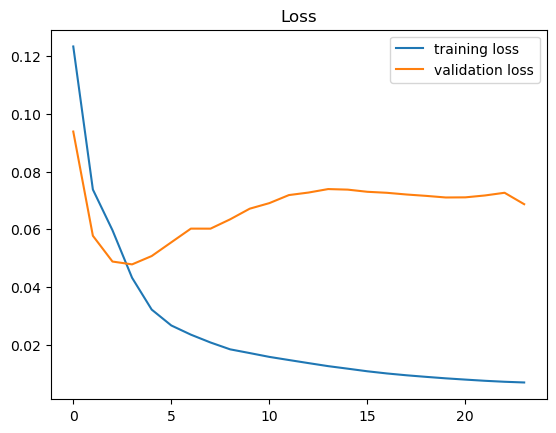

In [11]:
#early stopping callback that ends the training if the validation loss does not improve. It restores the best weights when the training is stopped
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#Trains the model with the training data and validates it with the validation data. The training is carried out with a batch size of 32 and an early stopping callback
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

Jetzt haben wir ein fertig trainiertes Modell, das wir zur Simulation von ungesehenen Daten (TestData) verwenden können.

### Tesdaten vorhersagen

Wir geben dafür *X_test* in das Modell und vergleichen die Vorhersage (sim) mit dem tatsächlich gemessenen Y_test (obs)

In [12]:
sim = model.predict(X_test) #Makes predictions with the trained model model on the test input X_test

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


### Fehlerwerte berechnen und Vorhersage plotten 

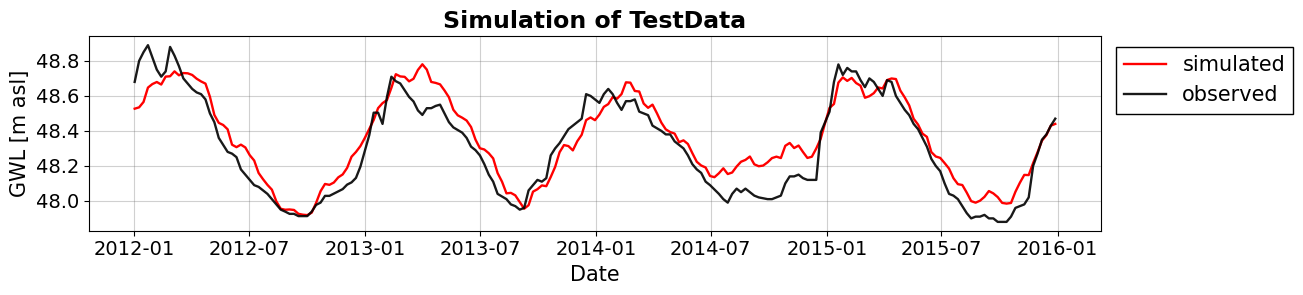

        NSE     RMSE         r      Bias
0  0.847926  0.10772  0.941496  0.050638


In [13]:
#Nash-Sutcliffe-Efficiency: NSE (NSE evaluates the prediction accuracy compared to the mean observation)
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias']) #Saves the calculated metrics (NSE, RMSE, r, bias) in a Pandas DataFrame scores

#Plot results
plt.figure(figsize=(13,3))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Simulation of TestData", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.2, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#show scores
print(scores)

### Regularisierungstechniken - robuste Modelle

Overfitting und Robustness sind zentrale Punkte für das Training von ANNs. Neben einem klassischen Early Stopping gegen Overfitting gibt es noch weitere Ansätze.

#### Batch-Normalization Layer

*tf.keras.layers.BatchNormalization()*  
https://www.tensorflow.org/versions/r2.7/api_docs/python/tf/keras/layers/BatchNormalization

Ihr kennt bereits das Vanishing Gradient Problem. BatchNorm Layer verhindern jetzt im Prinzip das Gegenteil, nämlich **Exploding Gradients**. Im Grunde wird dafür lediglich der Output des vorhergehenden Layers normalisiert.
Dies hat den Effekt, dass der Lernprozess stabilisiert und die Anzahl der Trainingsepochen, die zum Trainieren von Deep ANN benötigt werden, drastisch reduziert wird.

Mehr (ausführliche) Infos hier: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/  oder hier: https://towardsdatascience.com/batch-normalization-the-greatest-breakthrough-in-deep-learning-77e64909d81d

#### Dropout Layer

*tf.keras.layers.Dropout(rate)*  
https://www.tensorflow.org/versions/r2.7/api_docs/python/tf/keras/layers/Dropout

Durch einen Dropout Layer werden im Grunde ein definierter Anteil der möglichen Pfade im Netzwerk an dieser Stelle zufällig deaktiviert (zufällig immer andere bei jedem Durchlauf). Dadurch wird das Training verrauscht und die Nodes innerhalb einer Schicht gezwungen, besser auf Inputs zu reagieren.


#### Gaußian-Noise Layer
Prinzip: Den Daten wird Rauschen hinzugefügt, sodass das Model die Zusammenhänge robuster lernen kann. Wird heute nicht in dieser Übung behandelt.  
https://keras.io/api/layers/regularization_layers/ 

### Aufgabe 1: CNN

Macht euch mit dem Modell vertraut und verändert einmal folgende Parameter:  
- Anzahl der Inputparameter
- seq_length
- Anzahl der Filter im 1D-Conv Layer
- Training batch size
- Epochenanzahl und Early Stopping Patience

Wie ändert sich die Vorhersagegüte? Was für einenen NSE könnt ihr erreichen?

Was passiert wenn ihr die Lernrate auf 1E-4 herabsetzt und was ist eine mögliche Erklärung dafür, wenn ihr an die erste Vorlesung zu künstlichen neuronalen Netzen (wie diese trainiert werden/wie diese lernen) denkt?

### Aufgabe 2: LSTM
Ersetzt das 1D-CNN Modell durch ein LSTM. 
Hinweis: orientiert euch an folgender Struktur:


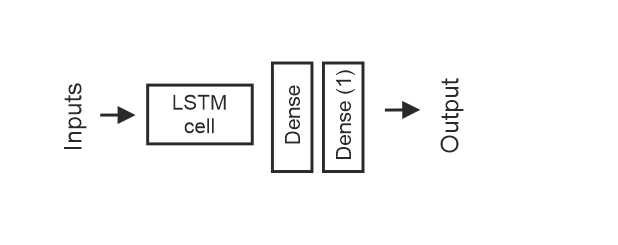

Ihr müsst also folgendes definieren:
2. Input Layer
3. LSTM Layer
4. Dense Layer
5. Dense Layer mit einem Output Neuron
(kein Pooling und kein Flatten Layer!)

Hier könnt ihr außerdem die Syntax für den LSTM Layer nachlesen:
https://www.tensorflow.org/versions/r2.7/api_docs/python/tf/keras/layers/LSTM (TF2.7)  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM (aktuellste TF Version)

Hinweis: **ihr müsst im LSTM layers nur "units" definieren**. Den Rest könnt ihr entsprechend den default Einstellungen nutzen.  
*LSTM(units)*


Welches des beiden Modelle erzielt eine bessere Performance? Fallen euch sonst Unterschiede auf, ist z.B. eines der Modelle schneller?



Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100


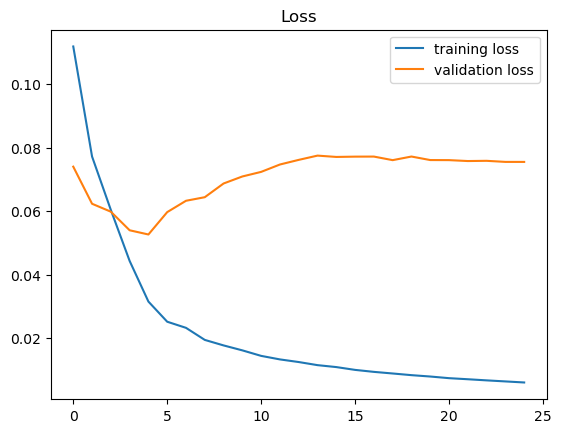

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
        NSE      RMSE         r     Bias
0  0.866629  0.100879  0.938072  0.03182


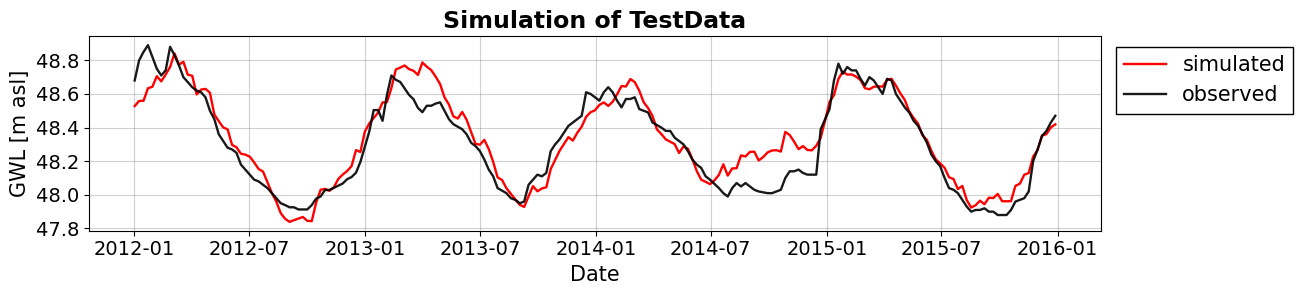

In [14]:
# set seed
seed(42)
tf.random.set_seed(42)

################################################################### 1D CNN Modell from above
#Input Layer
inp = Input(shape=(seq_length, X_train.shape[2]))

# #1D-Conv Layer
cnn = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(inp)

# #Pooling Layer
cnn = MaxPooling1D(padding='same')(cnn) 

#Flatten Layer
cnn = Flatten()(cnn) 

#Dense layer
dense =Dense(30, activation='relu')(cnn)

#Output Layer (Output Neuron)
output = Dense(1, activation='linear')(dense) 

#tie together
model = Model(inputs=inp, outputs=output)
########################################################################


#define optimizer
optimizer = Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
#compile the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

#define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

###################################
#simulate testset
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

###################################


#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))
#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))
#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r
#Bias
Bias = np.mean(sim-obs)
scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])
print(scores)

####################################

## plot Test data and simulation
plt.figure(figsize=(13,3))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Simulation of TestData", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.2, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Aufgabe 3: Regularisierungstechniken - robuste Modelle

Füge zu dem Modell aus Aufgabe 1 ODER 2 einen BatchNorm Layer und einen Dropout Layer hinzu. Experimentiere mit der Dropout Rate. Welchen Effekt haben die Layer einzeln und gleichzeitig?

**Hinweis**  
Orientiere dich bei der Platzierung fürs erste an dieser Struktur:

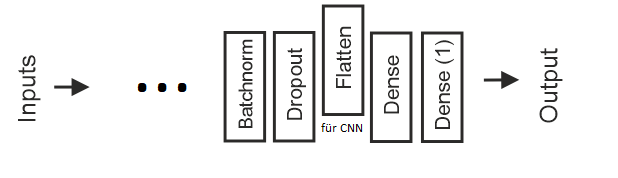



Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100


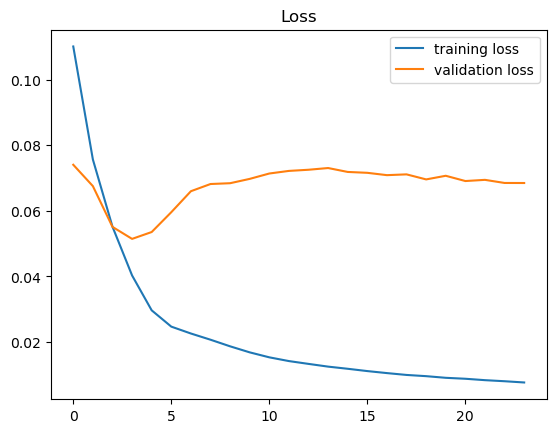

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
        NSE      RMSE         r    Bias
0  0.852399  0.106124  0.935103  0.0398


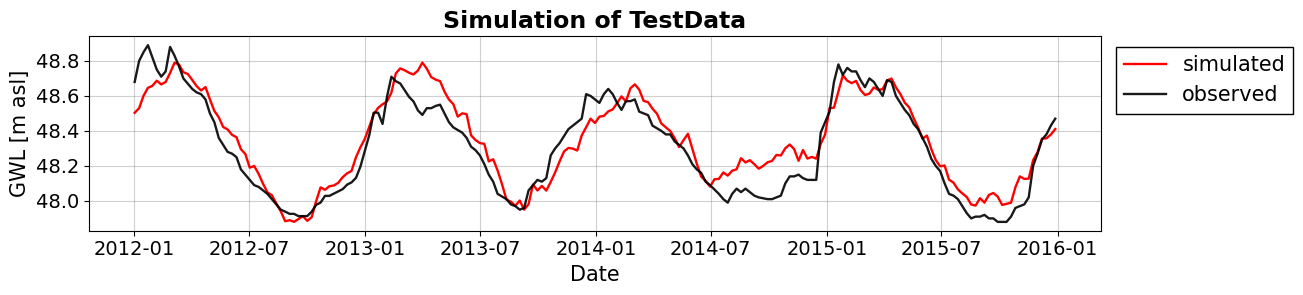

In [15]:
# set seed
seed(42)
tf.random.set_seed(42)

################################################################### 1D CNN Modell from above
#Input Layer
inp = Input(shape=(seq_length, X_train.shape[2]))

# #1D-Conv Layer
cnn = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(inp)

#Pooling Layer
cnn = MaxPooling1D(padding='same')(cnn) 

#Flatten Layer
cnn = Flatten()(cnn) 

#Dense layer
dense = Dense(30, activation='relu')(cnn)

#Output Layer (Output Neuron)
output = Dense(1, activation='linear')(dense) 

#tie together
model = Model(inputs=inp, outputs=output)
########################################################################

#define optimizer
optimizer = Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
#compile the model
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

#define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

###################################
#simulate testset
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))
###################################

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])
print(scores)

#plot Test data and simulation
plt.figure(figsize=(13,3))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Simulation of TestData", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.2, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Ihr könnt das natürlich auch mit einem LSTM statt einem CNN machen. 